In [2]:
import rasterio
from rasterio.windows import get_data_window,Window, from_bounds
import matplotlib.pyplot as plt
from rasterio.plot import show
from rasterio.enums import Resampling
import pandas as pd
import numpy as np
from shapely.geometry import Point
import geopandas as gpd
import datetime
from joblib import Parallel, delayed
import pyproj
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
from matplotlib import path 


/data2/lthapa/miniconda3/envs/ML_py/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [3]:
#fnction is from here: https://gis.stackexchange.com/questions/71630/subsetting-a-curvilinear-netcdf-file-roms-model-output-using-a-lon-lat-boundin
def bbox2ij(lon,lat,bbox):
    bbox=np.array(bbox)
    mypath=np.array([bbox[[0,1,1,0]],bbox[[2,2,3,3]]]).T
    p = path.Path(mypath)
    points = np.vstack((lon.flatten(),lat.flatten())).T
    n,m = np.shape(lon)
    inside = p.contains_points(points).reshape((n,m))
    ii,jj = np.meshgrid(range(m),range(n)) #ii is the columns, jj is the rows
    return min(ii[inside]),max(ii[inside]),min(jj[inside]),max(jj[inside])

In [4]:
#LAT and LON are 2d arrays
def calculate_grid_cell_corners(LAT, LON):
    #we will assume the very edges of the polygons don't touch the boundary of the domain
    lat_corners = (LAT[0:(LAT.shape[0]-1),  0:(LAT.shape[1])-1] + LAT[1:(LAT.shape[0]), 1:(LAT.shape[1])])/2
    lon_corners = (LON[0:(LAT.shape[0]-1),  0:(LAT.shape[1])-1] + LON[1:(LAT.shape[0]), 1:(LAT.shape[1])])/2
    return lat_corners, lon_corners

In [5]:
#makes and saves a geodataframe of a grid given the center and corner points for that grid as 2D matrices
def build_grid_netcdf(LAT_COR, LON_COR, LAT_CTR, LON_CTR, filename):
    #loop over the centers
    nrows_center = LAT_CTR.shape[0]
    ncols_center = LAT_CTR.shape[1]
    print(nrows_center, ncols_center)

    nrows_corner = LAT_COR.shape[0]
    ncols_corner = LAT_COR.shape[1]
    print(nrows_corner,ncols_corner)
    
    rows_ctr = np.arange(nrows_center)
    cols_ctr = np.arange(ncols_center)
    rows_cor = np.arange(nrows_corner)
    cols_cor = np.arange(ncols_corner)

    
    dat_grid = xr.Dataset(
        data_vars = dict(
            LAT_CTR=(['rows_ctr','cols_ctr'],LAT_CTR),
            LON_CTR=(['rows_ctr','cols_ctr'],LON_CTR),
            LAT_COR=(['rows_cor','cols_cor'],LAT_COR),
            LON_COR=(['rows_cor','cols_cor'],LON_COR),
        ),
        
        coords = dict(
            rows_ctr =(['rows_ctr'],rows_ctr),
            cols_ctr =(['cols_ctr'],cols_ctr),
            rows_cor =(['rows_cor'],rows_cor),
            cols_cor =(['cols_cor'],cols_cor),
        
        )
        
    )
    print(dat_grid)
    dat_grid.to_netcdf(filename+'.nc')

# Elevation (from tif file)

In [32]:
def build_one_coarse_elevation_cell(row_select,col_select,ii,jj,numcell):
    #print(ii,jj)
    win = Window(col_select[jj],row_select[ii],numcell,numcell)
    with rasterio.open('/data2/lthapa/static_maps/LF2020_Elev_220_CONUS/Tif/LC20_Elev_220.tif') as src:        
        w = src.read(1, window=win)
        row_win = np.arange(win.row_off,win.row_off+win.height)
        col_win = np.arange(win.col_off,win.col_off+win.width)
        COLS_WIN,ROWS_WIN=np.meshgrid(col_win,row_win)
        
        xs_win, ys_win = rasterio.transform.xy(src.transform, ROWS_WIN, COLS_WIN)
    #centers are the middle of the box
    y_ctr =(np.amin(ys_win)+np.amax(ys_win))/2
    x_ctr =(np.amin(xs_win)+np.amax(xs_win))/2
    #print(w_flat)
    #print(loadings.loc[w_flat])
    

    df_cell = pd.DataFrame()
    w=w.astype(float)
    w[w==-9999] = np.nan
    df_cell.loc[0,'mean_elev'] = np.nanmean(w)
    df_cell.loc[0,'std_elev'] = np.nanstd(w)
    df_cell.loc[0,'y_ctr']=y_ctr
    df_cell.loc[0,'x_ctr'] = x_ctr
    df_cell.loc[0,'row'] = ii
    df_cell.loc[0,'col'] = jj

    #toc = datetime.datetime.now()
    #print(toc-tic)
    return(df_cell.set_index(['row','col']))

In [33]:
#get the dimensions of the whole tif file
src = rasterio.open('/data2/lthapa/static_maps/LF2020_Elev_220_CONUS/Tif/LC20_Elev_220.tif') #data to coarsen

print(src.count) #number of bands/data layers
file_width = src.width
file_height = src.height
print(file_width, file_height) #1.5e10 points total!

row_coarse = np.arange(0, file_height,33)
col_coarse = np.arange(0,file_width,33)
print(len(row_coarse), len(col_coarse)) #1.5e7 points

COLS_WIN,ROWS_WIN=np.meshgrid(col_coarse,row_coarse)

#transform the coarsened grid into lat/lon, so we can select the bounding box
xs_win, ys_win = rasterio.transform.xy(src.transform, ROWS_WIN, COLS_WIN)

source_crs = 'epsg:5070' # Coordinate system of the file, conus Albers
target_crs = 'epsg:4326' # Global lat-lon coordinate system

conusAlbers_to_latlon = pyproj.Transformer.from_crs(source_crs, target_crs)
tic = datetime.datetime.now()
lat, lon = conusAlbers_to_latlon.transform(np.array(xs_win), np.array(ys_win))
toc = datetime.datetime.now()
print(toc-tic)

1
156335 101538
3077 4738
0:00:18.062976


0 2012 77 2398
2321 2012


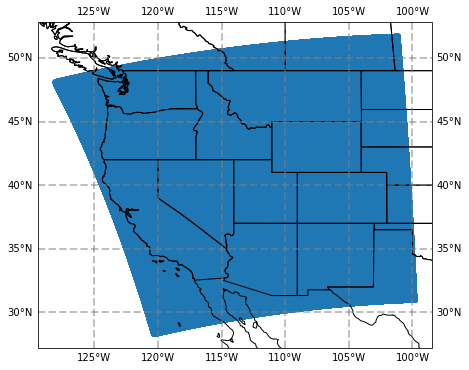

In [34]:
#select the bounding box
i0, i1, j0, j1 = bbox2ij(lon, lat, [-124, -101, 31, 49]) #original one
print(i0, i1, j0, j1)

#print(lon[j0:j1, i0:i1], lat[j0:j1, i0:i1])
row_sel = row_coarse[j0:j1] #indices in the bounding box
col_sel = col_coarse[i0:i1]

print(len(row_sel), len(col_sel)) #4.6e6 boxes

#plot the bounding box, sanity check
plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.scatter(x=lon[j0:j1,i0:i1],y=lat[j0:j1,i0:i1])
#plt.scatter(x=lon[j1,i0],y=lat[j1,i0])
#plt.scatter(x=lon[j0,i1],y=lat[j0,i1])
#plt.scatter(x=lon[j1,i1],y=lat[j1,i1])

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
plt.show()

In [38]:
#make the coarse cells
tic = datetime.datetime.now()
print(tic)
coarse_cells = Parallel(n_jobs=12)(delayed(build_one_coarse_elevation_cell)
                                 (row_sel,col_sel,xx,yy,33) 
                                 for xx in range(len(row_sel[0:1000])) for yy in range(len(col_sel[0:100])))
toc =datetime.datetime.now()
print(toc-tic)
coarse_cells_df = pd.concat(coarse_cells)
print(coarse_cells_df.columns)

2023-08-04 15:32:41.079532
0:03:58.905400
Index(['mean_elev', 'std_elev', 'y_ctr', 'x_ctr'], dtype='object')


In [39]:
tic = datetime.datetime.now()
#coarse_cells_df=coarse_cells_df.reset_index().set_index(['row','col'])
print(coarse_cells_df.iloc[0:1])
coarse_cells_xr = coarse_cells_df.to_xarray()

toc = datetime.datetime.now()
print(toc-tic)
print(coarse_cells_xr)

         mean_elev  std_elev      y_ctr      x_ctr
row col                                           
0.0 0.0        NaN       NaN  3190680.0 -2361900.0
0:00:00.028170
<xarray.Dataset>
Dimensions:    (col: 100, row: 1000)
Coordinates:
  * row        (row) float64 0.0 1.0 2.0 3.0 4.0 ... 996.0 997.0 998.0 999.0
  * col        (col) float64 0.0 1.0 2.0 3.0 4.0 ... 95.0 96.0 97.0 98.0 99.0
Data variables:
    mean_elev  (row, col) float64 nan nan nan ... 1.321e+03 1.625e+03 1.802e+03
    std_elev   (row, col) float64 nan nan nan nan ... 95.75 136.2 116.3 82.96
    y_ctr      (row, col) float64 3.191e+06 3.191e+06 ... 2.202e+06 2.202e+06
    x_ctr      (row, col) float64 -2.362e+06 -2.361e+06 ... -2.264e+06


In [40]:
source_crs = 'epsg:5070' # Coordinate system of the file, conus Albers
target_crs = 'epsg:4326' # Global lat-lon coordinate system

conusAlbers_to_latlon = pyproj.Transformer.from_crs(source_crs, target_crs)
lat, lon = conusAlbers_to_latlon.transform(coarse_cells_xr['x_ctr'].values, coarse_cells_xr['y_ctr'].values)

print(lat.shape)

lat_corners, lon_corners = calculate_grid_cell_corners(lat, lon)
print(lat_corners.shape)


#MAKE SURE THE PLOT LOOKS GOOD BEFORE DOING THIS
#put the grid into a netcdf
build_grid_netcdf(lat_corners, lon_corners, lat, lon, 'ELEV_GRID_990M')

#save the data in another netcdf
coarse_cells_xr=coarse_cells_xr.assign_coords(lat_ctr=(('row', 'col'), lat), 
                                              lon_ctr=(('row', 'col'), lon))


print(coarse_cells_xr['lon_ctr'].values)

print(coarse_cells_xr)
#coarse_cells_xr.to_netcdf('bobcat_fuel_fwi.nc')
coarse_cells_xr.to_netcdf('elev_990_test.nc')

(1000, 100)
(999, 99)
1000 100
999 99
<xarray.Dataset>
Dimensions:   (cols_cor: 99, cols_ctr: 100, rows_cor: 999, rows_ctr: 1000)
Coordinates:
  * rows_ctr  (rows_ctr) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * cols_ctr  (cols_ctr) int64 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99
  * rows_cor  (rows_cor) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998
  * cols_cor  (cols_cor) int64 0 1 2 3 4 5 6 7 8 ... 90 91 92 93 94 95 96 97 98
Data variables:
    LAT_CTR   (rows_ctr, cols_ctr) float64 48.1 48.1 48.1 ... 39.9 39.91 39.91
    LON_CTR   (rows_ctr, cols_ctr) float64 -128.0 -128.0 ... -123.1 -123.1
    LAT_COR   (rows_cor, cols_cor) float64 48.09 48.1 48.1 ... 39.91 39.91 39.91
    LON_COR   (rows_cor, cols_cor) float64 -128.0 -128.0 ... -123.1 -123.1
[[-128.03937995 -128.02694467 -128.01450826 ... -126.82788924
  -126.81534464 -126.80279892]
 [-128.03502189 -128.02258804 -128.01015306 ... -126.82367162
  -126.81112848 -126.79858423]
 [-128.03066498 -128.018232

# Make slope into 30m netcdf file? (can't allocate memory to do that)

In [7]:
#STEP 1: project the lat/lon
#get the dimensions of the whole tif file
src = rasterio.open('/data2/lthapa/static_maps/LF2020_SlpD_220_CONUS/Tif/LC20_SlpD_220.tif') #data to coarsen

print(src.count) #number of bands/data layers
file_width = src.width
file_height = src.height
print(file_width, file_height) #1.5e10 points total!

row_coarse = np.arange(0, file_height)#,66)
col_coarse = np.arange(0,file_width)#,66)
print(len(row_coarse), len(col_coarse)) #1.5e7 points

COLS_WIN,ROWS_WIN=np.meshgrid(col_coarse,row_coarse)

#transform the coarsened grid into lat/lon, so we can select the bounding box
xs_win, ys_win = rasterio.transform.xy(src.transform, ROWS_WIN, COLS_WIN)

source_crs = 'epsg:5070' # Coordinate system of the file, conus Albers
target_crs = 'epsg:4326' # Global lat-lon coordinate system

conusAlbers_to_latlon = pyproj.Transformer.from_crs(source_crs, target_crs)
tic = datetime.datetime.now()
lat, lon = conusAlbers_to_latlon.transform(np.array(xs_win), np.array(ys_win))
toc = datetime.datetime.now()
print(toc-tic)

1
156335 101538
101538 156335


MemoryError: Unable to allocate 118. GiB for an array with shape (101538, 156335) and data type int64

In [ ]:
#select the bounding box
i0, i1, j0, j1 = bbox2ij(lon, lat, [-124, -101, 31, 49]) #original one
print(i0, i1, j0, j1)

#print(lon[j0:j1, i0:i1], lat[j0:j1, i0:i1])
row_sel = row_coarse[j0:j1] #indices in the bounding box
col_sel = col_coarse[i0:i1]

print(len(row_sel), len(col_sel)) #4.6e6 boxes

# Slope (from tif file)

In [6]:
def build_one_coarse_slope_cell(row_select,col_select,ii,jj,numcell):
    #print(ii,jj)
    win = Window(col_select[jj],row_select[ii],numcell,numcell)
    with rasterio.open('/data2/lthapa/static_maps/LF2020_SlpD_220_CONUS/Tif/LC20_SlpD_220.tif') as src:        
        w = src.read(1, window=win)
        row_win = np.arange(win.row_off,win.row_off+win.height)
        col_win = np.arange(win.col_off,win.col_off+win.width)
        COLS_WIN,ROWS_WIN=np.meshgrid(col_win,row_win)
        
        xs_win, ys_win = rasterio.transform.xy(src.transform, ROWS_WIN, COLS_WIN)
    #centers are the middle of the box
    y_ctr =(np.amin(ys_win)+np.amax(ys_win))/2
    x_ctr =(np.amin(xs_win)+np.amax(xs_win))/2
    #print(w_flat)
    #print(loadings.loc[w_flat])
    

    df_cell = pd.DataFrame()
    w=w.astype(float)
    w[w==-9999] = np.nan
    df_cell.loc[0,'mean_slope'] = np.nanmean(w)
    df_cell.loc[0,'std_slope'] = np.nanstd(w)
    df_cell.loc[0,'y_ctr']=y_ctr
    df_cell.loc[0,'x_ctr'] = x_ctr
    df_cell.loc[0,'row'] = ii
    df_cell.loc[0,'col'] = jj

    #toc = datetime.datetime.now()
    #print(toc-tic)
    return(df_cell.set_index(['row','col']))

In [22]:
#get the dimensions of the whole tif file
src = rasterio.open('/data2/lthapa/static_maps/LF2020_SlpD_220_CONUS/Tif/LC20_SlpD_220.tif') #data to coarsen

print(src.count) #number of bands/data layers
file_width = src.width
file_height = src.height
print(file_width, file_height) #1.5e10 points total!

row_coarse = np.arange(0, file_height,66)
col_coarse = np.arange(0,file_width,66)
print(len(row_coarse), len(col_coarse)) #1.5e7 points

COLS_WIN,ROWS_WIN=np.meshgrid(col_coarse,row_coarse)

#transform the coarsened grid into lat/lon, so we can select the bounding box
xs_win, ys_win = rasterio.transform.xy(src.transform, ROWS_WIN, COLS_WIN)

source_crs = 'epsg:5070' # Coordinate system of the file, conus Albers
target_crs = 'epsg:4326' # Global lat-lon coordinate system

conusAlbers_to_latlon = pyproj.Transformer.from_crs(source_crs, target_crs)
tic = datetime.datetime.now()
lat, lon = conusAlbers_to_latlon.transform(np.array(xs_win), np.array(ys_win))
toc = datetime.datetime.now()
print(toc-tic)

1
156335 101538
1539 2369
0:00:04.438557


0 1006 39 1199
1160 1006


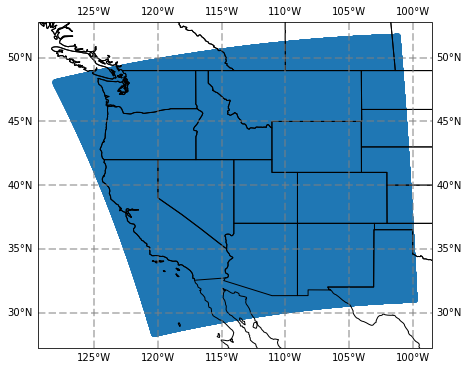

In [23]:
#select the bounding box
i0, i1, j0, j1 = bbox2ij(lon, lat, [-124, -101, 31, 49]) #original one
print(i0, i1, j0, j1)

#print(lon[j0:j1, i0:i1], lat[j0:j1, i0:i1])
row_sel = row_coarse[j0:j1] #indices in the bounding box
col_sel = col_coarse[i0:i1]

print(len(row_sel), len(col_sel)) #4.6e6 boxes

#plot the bounding box, sanity check
plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.scatter(x=lon[j0:j1,i0:i1],y=lat[j0:j1,i0:i1])
#plt.scatter(x=lon[j1,i0],y=lat[j1,i0])
#plt.scatter(x=lon[j0,i1],y=lat[j0,i1])
#plt.scatter(x=lon[j1,i1],y=lat[j1,i1])

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
plt.show()

In [24]:
#make the coarse cells
tic = datetime.datetime.now()
print(tic)
coarse_cells = Parallel(n_jobs=12)(delayed(build_one_coarse_slope_cell)
                                 (row_sel,col_sel,xx,yy,33) 
                                 for xx in range(len(row_sel[0:1000])) for yy in range(len(col_sel[0:100])))
toc =datetime.datetime.now()
print(toc-tic)
coarse_cells_df = pd.concat(coarse_cells)
print(coarse_cells_df.columns)

2023-08-04 14:57:01.829272
0:02:36.379397
Index(['mean_slope', 'std_slope', 'y_ctr', 'x_ctr'], dtype='object')


In [25]:
tic = datetime.datetime.now()
#coarse_cells_df=coarse_cells_df.reset_index().set_index(['row','col'])
print(coarse_cells_df.iloc[0:1])
coarse_cells_xr = coarse_cells_df.to_xarray()

toc = datetime.datetime.now()
print(toc-tic)
print(coarse_cells_xr)

         mean_slope  std_slope      y_ctr      x_ctr
row col                                             
0.0 0.0         NaN        NaN  3189690.0 -2361900.0
0:00:00.014885
<xarray.Dataset>
Dimensions:     (col: 100, row: 1000)
Coordinates:
  * row         (row) float64 0.0 1.0 2.0 3.0 4.0 ... 996.0 997.0 998.0 999.0
  * col         (col) float64 0.0 1.0 2.0 3.0 4.0 ... 95.0 96.0 97.0 98.0 99.0
Data variables:
    mean_slope  (row, col) float64 nan nan nan nan nan ... nan nan nan nan nan
    std_slope   (row, col) float64 nan nan nan nan nan ... nan nan nan nan nan
    y_ctr       (row, col) float64 3.19e+06 3.19e+06 ... 1.212e+06 1.212e+06
    x_ctr       (row, col) float64 -2.362e+06 -2.36e+06 ... -2.166e+06


In [26]:
source_crs = 'epsg:5070' # Coordinate system of the file, conus Albers
target_crs = 'epsg:4326' # Global lat-lon coordinate system

conusAlbers_to_latlon = pyproj.Transformer.from_crs(source_crs, target_crs)
lat, lon = conusAlbers_to_latlon.transform(coarse_cells_xr['x_ctr'].values, coarse_cells_xr['y_ctr'].values)

print(lat.shape)

lat_corners, lon_corners = calculate_grid_cell_corners(lat, lon)
print(lat_corners.shape)


#MAKE SURE THE PLOT LOOKS GOOD BEFORE DOING THIS
#put the grid into a netcdf
build_grid_netcdf(lat_corners, lon_corners, lat, lon, 'SLOPE_GRID_990M')

#save the data in another netcdf
coarse_cells_xr=coarse_cells_xr.assign_coords(lat_ctr=(('row', 'col'), lat), 
                                              lon_ctr=(('row', 'col'), lon))


print(coarse_cells_xr['lon_ctr'].values)

print(coarse_cells_xr)
#coarse_cells_xr.to_netcdf('bobcat_fuel_fwi.nc')
coarse_cells_xr.to_netcdf('slope_990_test.nc')

(1000, 100)
(999, 99)
1000 100
999 99
<xarray.Dataset>
Dimensions:   (cols_cor: 99, cols_ctr: 100, rows_cor: 999, rows_ctr: 1000)
Coordinates:
  * rows_ctr  (rows_ctr) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * cols_ctr  (cols_ctr) int64 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99
  * rows_cor  (rows_cor) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998
  * cols_cor  (cols_cor) int64 0 1 2 3 4 5 6 7 8 ... 90 91 92 93 94 95 96 97 98
Data variables:
    LAT_CTR   (rows_ctr, cols_ctr) float64 48.09 48.09 48.1 ... 31.59 31.59
    LON_CTR   (rows_ctr, cols_ctr) float64 -128.0 -128.0 ... -119.2 -119.1
    LAT_COR   (rows_cor, cols_cor) float64 48.08 48.09 48.09 ... 31.59 31.6 31.6
    LON_COR   (rows_cor, cols_cor) float64 -128.0 -128.0 ... -119.2 -119.2
[[-128.03502189 -128.01015306 -127.98527966 ... -125.60184928
  -125.57654878 -125.55124395]
 [-128.02630921 -128.00144608 -127.9765784  ... -125.59370612
  -125.56841166 -125.54311287]
 [-128.01760108 -127.99274365 